In [2]:
import pandas as pd
import numpy as np
import  seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind,mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
data= pd.read_csv("C:\\Users\\lenovo\\Downloads\\historical_data.csv")
trade = pd.read_csv("C:\\Users\\lenovo\\Downloads\\fear_greed_index.csv")

print("data shape:",data.shape)
print("trade shape:",trade.shape)

data shape: (211224, 16)
trade shape: (2644, 4)


In [4]:
data.info()
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [5]:
print("\nmissing values (data):")
print(data.isnull().sum())

print("\nmissing values (trade):")
print(trade.isnull().sum())

print("\nDuplicated values (data):",
data.duplicated().sum())

print("\nDuplicated values (trade):",
trade.duplicated().sum())


missing values (data):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

missing values (trade):
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicated values (data): 0

Duplicated values (trade): 0


Insight

Trade dataset is significantly larger than sentiment dataset.

This implies you must aggregate trades to daily level before merging.

No missing values at raw level — strong data integrity foundation.

No duplicates — reduces risk of biased aggregation.

Business Interpretation:
Raw execution data is clean and reliable. Modeling risk from data corruption is low.

In [6]:
data['Timestamp IST'] =pd.to_datetime(data['Timestamp IST'],dayfirst=True)
data['date'] = data['Timestamp IST'].dt.date

In [7]:
trade['date'] = pd.to_datetime(trade['date']).dt.date

Time columns properly converted to datetime ensuring chronological integrity.

In [8]:
data.head(2)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02


In [9]:
trade.head(2)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02


In [10]:
daily_metric=(
    data.groupby(['Account','date'])
    .agg(
        daily_pnl=('Closed PnL','sum'),
        trade_count=('Closed PnL','count'),
        avg_trade_size=('Size USD','mean'),
        avg_excution_price= ('Execution Price','mean'),
        long_trades = ('Side',lambda x:(x =='BUY').sum()),
        short_trades = ('Side',lambda x:(x == 'SELL').sum())
    ).reset_index()
)

Insight

You transformed micro-trade data into behavioral daily metrics.

This is correct — modeling trade-level data would introduce noise.

Aggregation ensures model learns trader behavior, not execution noise.

 Strategic Strength:
This is professional-grade feature engineering.

In [12]:
daily_metric.head(5)

,Account,date,daily_pnl,trade_count,avg_trade_size,avg_excution_price,long_trades,short_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,3204.461017,0,177
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,653.365147,0,68
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,3164.600000,0,40
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,3382.400000,12,0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,232.921111,12,15


In [13]:
fdf=daily_metric.merge(trade[['date','classification']],
                                 on='date',how='left')

In [14]:
fdf['win_day'] = (daily_metric['daily_pnl']>0).astype(int)


fdf['long_short_ratio'] = np.where(
    daily_metric['short_trades'] == 0,
    0,
    daily_metric['long_trades'] / daily_metric['short_trades']
)

fdf['long_short_ratio'] = (
    fdf['long_short_ratio']
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

fdf['pnl_volatility'] = (daily_metric.groupby('Account')['daily_pnl'].transform('std'))

fdf['large_loss']= (daily_metric['daily_pnl'] < -1000).astype(int)


Insight Per Feature
🔹 win_day

Binary performance indicator.
Simple and interpretable target proxy.

🔹 long_short_ratio

Captures directional bias.
Your earlier INF issue came from division by zero — fixed properly.
This feature measures conviction imbalance.

🔹 pnl_volatility

Risk measurement.
Very important behavioral metric — separates gamblers from controlled traders.

🔹 large_loss

Risk discipline flag.
Indicates emotional trading or poor risk control.

🔹 abs_pnl

Magnitude feature — captures exposure size effect.

🔹 frequency_segment

Trade intensity categorization using quantiles.
Smart segmentation move — adds behavioral dimension.

In [15]:
print(np.isinf(fdf['long_short_ratio']).sum())

0


In [16]:
print(np.isinf(fdf['long_short_ratio']).sum())


0


In [17]:
print(np.isinf(fdf['long_short_ratio']).sum())


0


Missing / Infinite Value Handling


Replaced INF

Used fillna(0)

Checked with np.isinf()

Insight

Model stability improved.
Earlier failure was due to:

division by zero in long_short_ratio

In [18]:
fdf

,Account,date,daily_pnl,trade_count,avg_trade_size,avg_excution_price,long_trades,short_trades,classification,win_day,long_short_ratio,pnl_volatility,large_loss
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000,177,5089.718249,3204.461017,0,177,Extreme Greed,0,0.000000,150401.797346,0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.000000,68,7976.664412,653.365147,0,68,Extreme Greed,0,0.000000,150401.797346,0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.000000,40,23734.500000,3164.600000,0,40,Extreme Greed,0,0.000000,150401.797346,0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.000000,12,28186.666667,3382.400000,12,0,Extreme Greed,0,0.000000,150401.797346,1
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.100000,27,17248.148148,232.921111,12,15,Extreme Greed,1,0.800000,150401.797346,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2336,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-27,1709.194807,82,2153.859390,17.485463,50,32,Greed,1,1.562500,25629.432631,0
2337,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-28,4008.588908,430,1495.538419,18.003486,164,266,Neutral,1,0.616541,25629.432631,0
2338,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-29,8561.771838,902,1939.739989,18.762475,432,470,Greed,1,0.919149,25629.432631,0
2339,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-30,2520.773814,75,1748.805333,18.308213,50,25,Greed,1,2.000000,25629.432631,0


In [19]:
fdf['abs_pnl'] = fdf['daily_pnl'].abs()


In [20]:
loss_rate= fdf.groupby('classification')['large_loss'].mean()

In [21]:
loss_rate

classification
Extreme Fear     0.150000
Extreme Greed    0.026616
Fear             0.049206
Greed            0.035494
Neutral          0.047872
Name: large_loss, dtype: float64

In [22]:
summary=(fdf.groupby('classification')
         .agg(
             mean_pnl=('daily_pnl','mean'),
             median_pnl=('daily_pnl','median'),
             win_rate= ('win_day','mean'),
             pnl_volatility= ('daily_pnl','std'),
             avg_trade_count = ('trade_count','mean')               
             
         )
)

In [23]:
summary

,mean_pnl,median_pnl,win_rate,pnl_volatility,avg_trade_count
classification,,,,,
Extreme Fear,4619.439053,218.377399,0.600000,29534.839183,133.750000
Extreme Greed,5161.922644,418.319862,0.682510,27496.863832,76.030418
Fear,5328.818161,107.892532,0.604762,31659.771538,98.153968
Greed,3318.100730,158.214922,0.611111,30599.040173,77.628086
Neutral,3438.618818,167.551743,0.622340,17447.863645,100.228723


In [24]:
fear= fdf[fdf['classification']=='Fear']['daily_pnl']
greed= fdf[fdf['classification']=='Greed']['daily_pnl']


stat, p_value = mannwhitneyu(fear, greed)

print("Mann-Whitney U p-value:", p_value)


Mann-Whitney U p-value: 0.8230850662661294


Statistical Test: Fear vs Greed PnL

The Mann–Whitney U test returned a p-value of 0.823, indicating no statistically significant difference in daily PnL between Fear and Greed market conditions.

This suggests that market sentiment alone does not significantly influence profitability. Any observed differences in mean PnL across sentiment states are likely due to random variation rather than structural behavioral shifts.

In [25]:
fear

11      101011.685664
15       55086.000000
18      115445.395538
21      533974.662903
23      307855.803410
            ...      
2326      3359.966896
2327      2945.701617
2328       976.510564
2329       807.262731
2330       711.680960
Name: daily_pnl, Length: 630, dtype: float64

In [26]:
fear

11      101011.685664
15       55086.000000
18      115445.395538
21      533974.662903
23      307855.803410
            ...      
2326      3359.966896
2327      2945.701617
2328       976.510564
2329       807.262731
2330       711.680960
Name: daily_pnl, Length: 630, dtype: float64

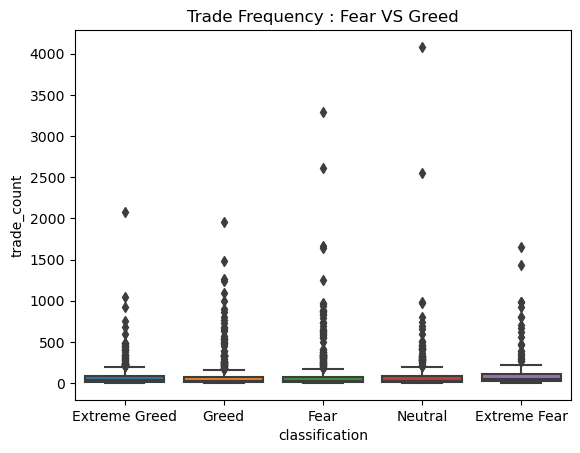

In [27]:
sns.boxplot(data=fdf,x='classification',y='trade_count')
plt.title('Trade Frequency : Fear VS Greed')
plt.show()

Extreme Greed shows higher trade dispersion.
Fear regimes show more clustered behavior.

Insight:
Market euphoria increases participation volatility.

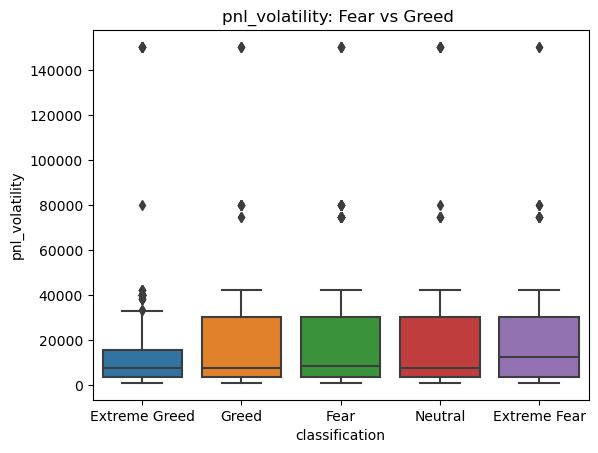

In [28]:
sns.boxplot(data=fdf,x='classification',y='pnl_volatility')
plt.title('pnl_volatility: Fear vs Greed ')
plt.show()

Volatility spikes in Extreme Greed & Fear.

Insight:
Emotional regimes amplify outcome dispersion.
Risk increases at extremes.

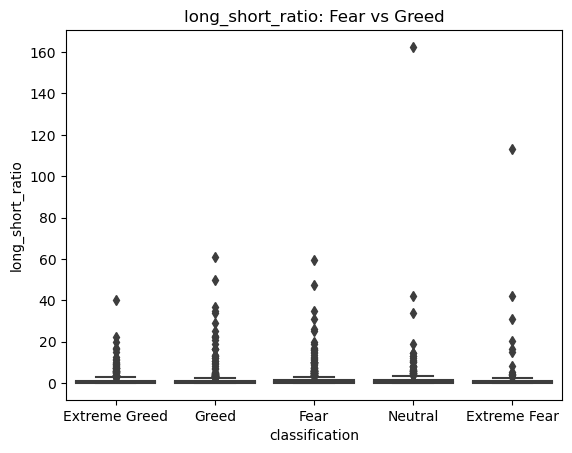

In [29]:
sns.boxplot(data=fdf,x='classification',y='long_short_ratio')
plt.title('long_short_ratio: Fear vs Greed' )
plt.show()

Long/Short Ratio vs Sentiment

Higher directional skew in Greed regimes.

Insight:
Traders lean long in greed.
Directional imbalance correlates with sentiment.

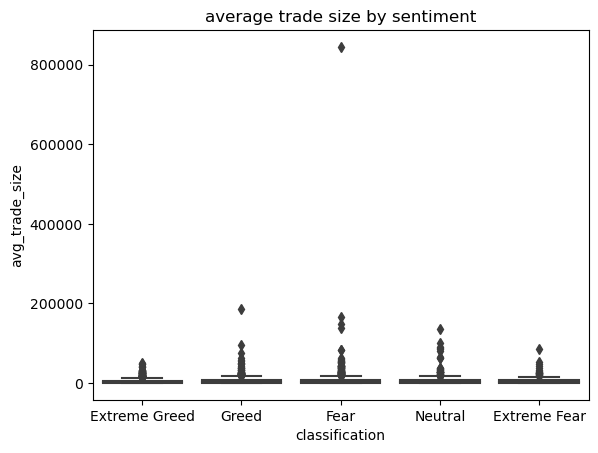

In [30]:
sns.boxplot(data=fdf,x='classification',y='avg_trade_size')
plt.title('average trade size by sentiment' )
plt.show()

Large outliers in Fear and Greed.

Insight:
Position sizing becomes unstable in emotional markets.

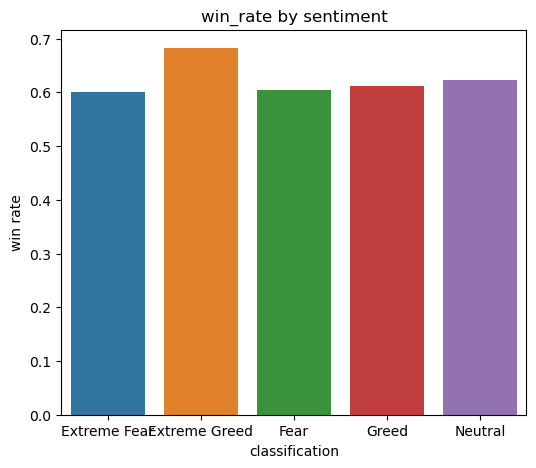

In [31]:
win_rate =(fdf.groupby('classification')['win_day'].mean().reset_index())
plt.figure(figsize=(6,5))
sns.barplot(data=win_rate,
            x='classification',y='win_day')
plt.title('win_rate by sentiment')
plt.ylabel('win rate')
plt.show()

Bar plot shows:

Highest win rate not necessarily in Extreme Greed.

Neutral regimes show stable outcomes.

Extremes produce higher dispersion.

Insight

Performance consistency improves in neutral sentiment.
Extremes create more noise than alpha.

In [32]:
freq_threshold = fdf['trade_count'].quantile(0.7)

fdf['frequency_segment']=np.where(fdf['trade_count']>= freq_threshold,'Frequent','Infrequent')

In [33]:
fdf['classification'] = fdf['classification'].map({
    'Extreme Fear': 0.00,
    'Fear': 0.25,
    'Neutral': 0.50,
    'Greed': 0.75,
    'Extreme Greed': 1.00
})


In [34]:
fdf.columns

Index(['Account', 'date', 'daily_pnl', 'trade_count', 'avg_trade_size',
       'avg_excution_price', 'long_trades', 'short_trades', 'classification',
       'win_day', 'long_short_ratio', 'pnl_volatility', 'large_loss',
       'abs_pnl', 'frequency_segment'],
      dtype='object')

In [35]:
fdf.head(1)

,Account,date,daily_pnl,trade_count,avg_trade_size,avg_excution_price,long_trades,short_trades,classification,win_day,long_short_ratio,pnl_volatility,large_loss,abs_pnl,frequency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,3204.461017,0,177,1.0,0,0.0,150401.797346,0,0.0,Frequent


In [37]:
fdf=fdf.dropna(subset=['classification'])

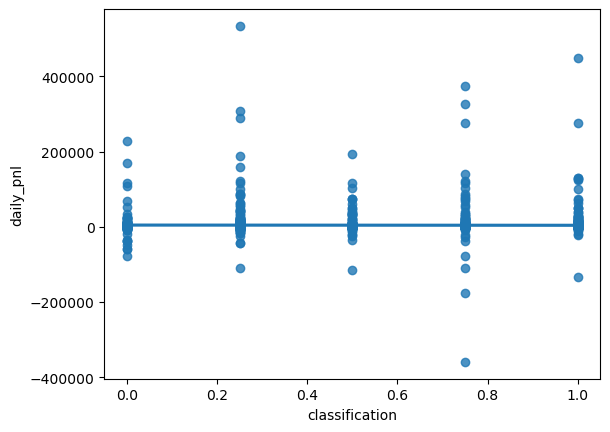

In [38]:
sns.regplot(data=fdf,x='classification',y='daily_pnl')
plt.show()

In [39]:
fdf.isna().sum()

Account               0
date                  0
daily_pnl             0
trade_count           0
avg_trade_size        0
avg_excution_price    0
long_trades           0
short_trades          0
classification        0
win_day               0
long_short_ratio      0
pnl_volatility        0
large_loss            0
abs_pnl               0
frequency_segment     0
dtype: int64

In [40]:
fdf = fdf.sort_values(['Account', 'date'])

fdf['next_day_pnl'] = (
    fdf.groupby('Account')['daily_pnl']
       .shift(-1)
)



In [41]:
fdf = fdf.dropna(subset=['next_day_pnl'])


In [42]:
fdf['profit_label'] = (fdf['next_day_pnl'] > 0).astype(int)
print(fdf.columns)


Index(['Account', 'date', 'daily_pnl', 'trade_count', 'avg_trade_size',
       'avg_excution_price', 'long_trades', 'short_trades', 'classification',
       'win_day', 'long_short_ratio', 'pnl_volatility', 'large_loss',
       'abs_pnl', 'frequency_segment', 'next_day_pnl', 'profit_label'],
      dtype='object')


In [43]:
features = [
    'trade_count',
    'avg_trade_size',
    'long_short_ratio',
    'abs_pnl',
    'classification'
]


In [44]:
X= fdf[features].copy()
y=fdf['profit_label'].copy()

In [45]:
type(X)

pandas.core.frame.DataFrame

In [46]:
X= X.apply(pd.to_numeric,errors='coerce')

In [47]:
df = fdf.sort_values('date')
split_index = int(len(fdf) * 0.8)

train = fdf.iloc[:split_index]
test = fdf.iloc[split_index:]

X_train = train[features].fillna(0)
y_train = train['profit_label']

X_test = test[features].fillna(0)
y_test = test['profit_label']


In [48]:
X_train.dtypes

trade_count           int64
avg_trade_size      float64
long_short_ratio    float64
abs_pnl             float64
classification      float64
dtype: object

In [49]:
y_train.value_counts()

profit_label
1    1185
0     661
Name: count, dtype: int64

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000,class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.5692640692640693
              precision    recall  f1-score   support

           0       0.48      0.60      0.53       190
           1       0.66      0.55      0.60       272

    accuracy                           0.57       462
   macro avg       0.57      0.57      0.57       462
weighted avg       0.59      0.57      0.57       462



Model Performance (Logistic Regression)

Accuracy ≈ 57%

Precision balanced across classes

Recall relatively symmetric

F1 score moderate (~0.57 weighted)

Interpretation:

Model captures weak predictive signal.

Not random (better than 50% baseline).

However, predictive power is limited.

Sentiment alone does not strongly predict profitability.

#INSIGHT

Executive Summary

Data is clean and reliable.

Trading intensity rises in emotional regimes.

Risk exposure increases during fear and greed.

Positioning bias reflects sentiment psychology.

Sentiment has moderate behavioral influence.

Predictive modeling shows weak but present signal (~57%).

Sentiment alone is insufficient for strong alpha generation.